In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

# resnet ablation study
## resnet의 구조
![resnet](https://github.com/user-attachments/assets/065687c6-2711-4296-8844-7bf3099437b9)
![resnet_block](https://github.com/user-attachments/assets/e9ed45ab-5189-49cb-8205-4626c1ec89c8)
![resnet_structure](https://github.com/user-attachments/assets/2a0b8e9e-8a3c-465f-92e4-ea9a9a5c69fd)

## 작성해볼 resnet은 34와 50
### 공통점
- conv block을 반복해서 쌓은 형태
- 7x7커널의 conv1과 3x3의 maxpool층을 거친 후 conv block으로 진행  

### 차이점
- conv block의 내부 구조가 다름
    - 34에서는 3x3커널을 사용한 2개의 conv 레이어로 구성되어 있지만 50에서는 1x1, 3x3, 1x1의 3개의 conv 레이어로 구성되어 있음
    - bottleneck 구조
        - 계산 효율성을 높이고 네트워크의 깊이를 증가 시킬 수 있음  
        
## 코드 진행
1. resnet의 conv블럭과 이것을 포함한 resnet 빌드함수 구현
    - 34층 50층을 선택할 수 있도록 is_50 구성
    - plain모델과 residual connection기능을 구현한 is_plain 구성
2. 데이터셋 구성
3. resnet_34부터 plain_34, resnet_50, plain_50순으로 빌드 및 훈련, 기록
    - 각 모델별 사용 후 메모리 해제를 통해 메모리 관리
4. 결과 시각화

In [2]:
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    x = input_layer
    if is_50:
        is50_n = 1
    else:
        is50_n = 0
    if is_plain:
        isplain_n = 1
    else:
        isplain_n = 0
        
    if not is_50:
        for i in range(num_cnn):
            identity = x
            if block_num !=0 and i==0:
                stride = 2
            else:
                stride = 1
            x = keras.layers.Conv2D(filters=channel, kernel_size = 3, activation='relu', kernel_initializer='he_normal', strides=stride, padding = 'same', name=f'stage{block_num}_{i}_conv1_{is50_n}{isplain_n}')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters=channel, kernel_size = 3, activation='relu', kernel_initializer='he_normal', padding = 'same', name=f'stage{block_num}_{i}_conv2_{is50_n}{isplain_n}')(x)
            x = keras.layers.BatchNormalization()(x)

            #플레인 모델에서는 잔차연결x
            if not is_plain:
                # identity mapping의 channel 수를 맞추기 위해 1x1 Convolution을 사용합니다.
                if i==0:
                    identity = keras.layers.Conv2D(filters=x.shape[-1], kernel_size=1, strides=stride, padding='same', name=f'identity_{block_num}_{i}_{is50_n}{isplain_n}')(identity)
                #add
                x = keras.layers.Add()([x, identity])
                x = keras.layers.Activation('relu')(x)
    else:
        for i in range(num_cnn):
            identity = x
            if block_num !=0 and i==0:
                stride = 2
            else:
                stride = 1
            x = keras.layers.Conv2D(filters=channel, kernel_size = 1, activation='relu', kernel_initializer='he_normal', strides=stride, padding = 'same', name=f'stage{block_num}_{i}_conv1_{is50_n}{isplain_n}')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters=channel, kernel_size = 3, activation='relu', kernel_initializer='he_normal', padding = 'same', name=f'stage{block_num}_{i}_conv2_{is50_n}{isplain_n}')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(filters=channel*4, kernel_size = 1, activation='relu', kernel_initializer='he_normal', padding = 'same', name=f'stage{block_num}_{i}_conv3_{is50_n}{isplain_n}')(x)
            x = keras.layers.BatchNormalization()(x)

            #플레인 모델에서는 잔차연결x
            if not is_plain:
                identity = keras.layers.Conv2D(filters=channel*4, kernel_size = 1, activation='relu', kernel_initializer='he_normal', strides=stride, padding = 'same', name=f'identity_{block_num}_{i}_{is50_n}{isplain_n}')(identity)
                identity = keras.layers.BatchNormalization()(identity)
                #add
                x = keras.layers.Add()([x, identity])
                x = keras.layers.Activation('relu')(x)
    return x

In [3]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):

    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    output = keras.layers.Conv2D(filters=64, kernel_size = 7, activation='relu', strides = 2, padding = 'same')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)

    # conv2 pooling
    output = keras.layers.MaxPooling2D(pool_size = 3, strides = 2, padding = 'same')(output)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            is_50 = is_50,
            is_plain = is_plain
        )

    output = keras.layers.AveragePooling2D(pool_size=2, padding = 'same', name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)

    model = keras.models.Model(inputs=input_layer, outputs=output)
    return model

In [4]:
resnet_34 = build_resnet(input_shape=(224,224,3))
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

In [6]:
# 데이터셋 로드 및 전처리
def preprocess(image, label, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def load_data(dataset_name='cats_vs_dogs', batch_size=32, target_size=(224, 224)):
    (train_ds, val_ds), ds_info = tfds.load(
        dataset_name,
        split=['train[:80%]', 'train[80%:]'],
        as_supervised=True,
        with_info=True,
    )
    num_classes = ds_info.features['label'].num_classes
    train_ds = train_ds.map(lambda x, y: preprocess(x, y, target_size)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: preprocess(x, y, target_size)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, num_classes

In [7]:
BATCH_SIZE = 32
EPOCH = 15

setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
dataset_name = 'cats_vs_dogs'

ds_train, ds_test, num_classes = load_data(dataset_name, batch_size=BATCH_SIZE, target_size=(224, 224))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [8]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res34 = resnet_34.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/582 [=========>....................] - ETA: 1:05 - loss: 1.3643 - accuracy: 0.5083

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 1.3307 - accuracy: 0.5127

238/582 [===========>..................] - ETA: 58s - loss: 1.3248 - accuracy: 0.5131

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 1.2684 - accuracy: 0.5206

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


518/582 [=========================>....] - ETA: 11s - loss: 1.1908 - accuracy: 0.5262

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


531/582 [==========================>...] - ETA: 8s - loss: 1.1853 - accuracy: 0.5278

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 1.1829 - accuracy: 0.5280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 1.1735 - accuracy: 0.5295

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 1.1723 - accuracy: 0.5295

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.1738 - accuracy: 0.5286

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 170s 195ms/step - loss: 1.1738 - accuracy: 0.5286 - val_loss: 1.0169 - val_accuracy: 0.5054
Epoch 2/15
195/582 [=========>....................] - ETA: 1:10 - loss: 1.0290 - accuracy: 0.5277

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 1.0289 - accuracy: 0.5304

237/582 [===========>..................] - ETA: 1:02 - loss: 1.0323 - accuracy: 0.5295

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 1.0340 - accuracy: 0.5283

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 1.0140 - accuracy: 0.5350

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 1.0108 - accuracy: 0.5354

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 1.0086 - accuracy: 0.5360

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 1.0062 - accuracy: 0.5365

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 1.0060 - accuracy: 0.5359

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.5354

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 1.0069 - accuracy: 0.5354 - val_loss: 1.5967 - val_accuracy: 0.5387
Epoch 3/15
195/582 [=========>....................] - ETA: 1:11 - loss: 0.9452 - accuracy: 0.5545

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:05 - loss: 0.9463 - accuracy: 0.5508

237/582 [===========>..................] - ETA: 1:03 - loss: 0.9476 - accuracy: 0.5506

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 50s - loss: 0.9398 - accuracy: 0.5548

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.9282 - accuracy: 0.5553

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.9281 - accuracy: 0.5552

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.9277 - accuracy: 0.5550

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.9272 - accuracy: 0.5544

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.9280 - accuracy: 0.5540

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.9291 - accuracy: 0.5537

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.9291 - accuracy: 0.5537 - val_loss: 1.3489 - val_accuracy: 0.4979
Epoch 4/15
195/582 [=========>....................] - ETA: 1:11 - loss: 0.8973 - accuracy: 0.5519

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:05 - loss: 0.8999 - accuracy: 0.5501

237/582 [===========>..................] - ETA: 1:03 - loss: 0.9040 - accuracy: 0.5492

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 50s - loss: 0.9160 - accuracy: 0.5425

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.9230 - accuracy: 0.5398

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.9230 - accuracy: 0.5404

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.9215 - accuracy: 0.5405

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.9185 - accuracy: 0.5404

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.9174 - accuracy: 0.5405

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.9186 - accuracy: 0.5400

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.9186 - accuracy: 0.5400 - val_loss: 0.9184 - val_accuracy: 0.5155
Epoch 5/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.8915 - accuracy: 0.5391

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.8883 - accuracy: 0.5407

237/582 [===========>..................] - ETA: 1:03 - loss: 0.8884 - accuracy: 0.5406

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.8873 - accuracy: 0.5381

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.8876 - accuracy: 0.5415

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.8877 - accuracy: 0.5420

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.8864 - accuracy: 0.5424

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.8850 - accuracy: 0.5434

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8845 - accuracy: 0.5434

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.5431

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.8857 - accuracy: 0.5431 - val_loss: 1.0720 - val_accuracy: 0.5800
Epoch 6/15
195/582 [=========>....................] - ETA: 1:11 - loss: 0.8607 - accuracy: 0.5423

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:05 - loss: 0.8571 - accuracy: 0.5450

237/582 [===========>..................] - ETA: 1:03 - loss: 0.8595 - accuracy: 0.5427

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 50s - loss: 0.8577 - accuracy: 0.5465

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.8507 - accuracy: 0.5463

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.8503 - accuracy: 0.5458

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.8518 - accuracy: 0.5465

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.8501 - accuracy: 0.5470

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8507 - accuracy: 0.5464

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8522 - accuracy: 0.5455

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.8522 - accuracy: 0.5455 - val_loss: 0.8301 - val_accuracy: 0.5275
Epoch 7/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.8174 - accuracy: 0.5675

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.8170 - accuracy: 0.5694

237/582 [===========>..................] - ETA: 1:03 - loss: 0.8195 - accuracy: 0.5680

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.8221 - accuracy: 0.5641

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.8185 - accuracy: 0.5628

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.8200 - accuracy: 0.5618

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.8204 - accuracy: 0.5612

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.8205 - accuracy: 0.5613

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8213 - accuracy: 0.5605

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.5603

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 195ms/step - loss: 0.8211 - accuracy: 0.5603 - val_loss: 0.7924 - val_accuracy: 0.5456
Epoch 8/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.8247 - accuracy: 0.5494

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.8215 - accuracy: 0.5456

237/582 [===========>..................] - ETA: 1:03 - loss: 0.8255 - accuracy: 0.5448

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.8218 - accuracy: 0.5439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.8169 - accuracy: 0.5462

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.8176 - accuracy: 0.5462

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.8180 - accuracy: 0.5465

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.8165 - accuracy: 0.5470

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8169 - accuracy: 0.5467

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.5462

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.8169 - accuracy: 0.5462 - val_loss: 0.9032 - val_accuracy: 0.5269
Epoch 9/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.7900 - accuracy: 0.5611

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:05 - loss: 0.7929 - accuracy: 0.5559

237/582 [===========>..................] - ETA: 1:03 - loss: 0.7959 - accuracy: 0.5538

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.8001 - accuracy: 0.5527

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.8000 - accuracy: 0.5529

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.7985 - accuracy: 0.5537

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7996 - accuracy: 0.5535

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7989 - accuracy: 0.5529

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7988 - accuracy: 0.5525

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.5515

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.7993 - accuracy: 0.5515 - val_loss: 0.7986 - val_accuracy: 0.5413
Epoch 10/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.8041 - accuracy: 0.5410

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.8057 - accuracy: 0.5421

237/582 [===========>..................] - ETA: 1:03 - loss: 0.8085 - accuracy: 0.5423

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 50s - loss: 0.8106 - accuracy: 0.5391

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.8026 - accuracy: 0.5390

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.8045 - accuracy: 0.5381

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.8038 - accuracy: 0.5385

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.8020 - accuracy: 0.5384

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8019 - accuracy: 0.5385

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8019 - accuracy: 0.5384

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.8019 - accuracy: 0.5384 - val_loss: 0.7843 - val_accuracy: 0.5479
Epoch 11/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.7762 - accuracy: 0.5558

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.7744 - accuracy: 0.5566

237/582 [===========>..................] - ETA: 1:03 - loss: 0.7774 - accuracy: 0.5559

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 50s - loss: 0.7752 - accuracy: 0.5575

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7783 - accuracy: 0.5525

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.7765 - accuracy: 0.5535

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7771 - accuracy: 0.5533

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7768 - accuracy: 0.5527

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7774 - accuracy: 0.5523

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7769 - accuracy: 0.5523

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.7769 - accuracy: 0.5523 - val_loss: 0.8291 - val_accuracy: 0.5555
Epoch 12/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.7633 - accuracy: 0.5580

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.7645 - accuracy: 0.5599

237/582 [===========>..................] - ETA: 1:03 - loss: 0.7663 - accuracy: 0.5605

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.7642 - accuracy: 0.5642

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7621 - accuracy: 0.5620

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.7616 - accuracy: 0.5621

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7619 - accuracy: 0.5625

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7637 - accuracy: 0.5614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7641 - accuracy: 0.5609

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7640 - accuracy: 0.5616

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 195ms/step - loss: 0.7640 - accuracy: 0.5616 - val_loss: 0.8362 - val_accuracy: 0.5460
Epoch 13/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.7538 - accuracy: 0.5631

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.7519 - accuracy: 0.5633

237/582 [===========>..................] - ETA: 1:03 - loss: 0.7564 - accuracy: 0.5592

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.7598 - accuracy: 0.5569

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7571 - accuracy: 0.5566

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.7558 - accuracy: 0.5573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7561 - accuracy: 0.5582

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7556 - accuracy: 0.5577

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7557 - accuracy: 0.5574

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.5572

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.7564 - accuracy: 0.5572 - val_loss: 0.8535 - val_accuracy: 0.5492
Epoch 14/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.7615 - accuracy: 0.5538

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.7570 - accuracy: 0.5566

237/582 [===========>..................] - ETA: 1:03 - loss: 0.7589 - accuracy: 0.5559

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.7603 - accuracy: 0.5529

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7610 - accuracy: 0.5535

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.7604 - accuracy: 0.5539

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7601 - accuracy: 0.5543

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7600 - accuracy: 0.5555

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7603 - accuracy: 0.5548

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.5544

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 195ms/step - loss: 0.7603 - accuracy: 0.5544 - val_loss: 0.7988 - val_accuracy: 0.5290
Epoch 15/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.7581 - accuracy: 0.5601

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:05 - loss: 0.7591 - accuracy: 0.5608

237/582 [===========>..................] - ETA: 1:03 - loss: 0.7620 - accuracy: 0.5591

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.7591 - accuracy: 0.5588

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7612 - accuracy: 0.5557

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.7607 - accuracy: 0.5560

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7599 - accuracy: 0.5568

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7611 - accuracy: 0.5564

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7614 - accuracy: 0.5561

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7615 - accuracy: 0.5558

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.7615 - accuracy: 0.5558 - val_loss: 0.7945 - val_accuracy: 0.5617


In [9]:
del resnet_34

plain_34 = build_resnet(input_shape=(224,224,3),is_plain=True)
plain_34.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_33 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_33 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage0_0_conv1_01 (Conv2D)   (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_34 (Batc (None, 56, 56, 64)        256 

In [10]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain34 = plain_34.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.9274 - accuracy: 0.5016

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.9108 - accuracy: 0.5043

237/582 [===========>..................] - ETA: 58s - loss: 0.9069 - accuracy: 0.5033

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.8761 - accuracy: 0.5049

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.8380 - accuracy: 0.5110

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.8356 - accuracy: 0.5113

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.8347 - accuracy: 0.5113

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.8299 - accuracy: 0.5134

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8296 - accuracy: 0.5133

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.5131

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 184ms/step - loss: 0.8288 - accuracy: 0.5131 - val_loss: 0.7234 - val_accuracy: 0.5198
Epoch 2/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7607 - accuracy: 0.5237

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7642 - accuracy: 0.5223

237/582 [===========>..................] - ETA: 59s - loss: 0.7659 - accuracy: 0.5208

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7629 - accuracy: 0.5245

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7683 - accuracy: 0.5218

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7688 - accuracy: 0.5218

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7688 - accuracy: 0.5224

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7684 - accuracy: 0.5227

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7684 - accuracy: 0.5224

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7682 - accuracy: 0.5225

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.7682 - accuracy: 0.5225 - val_loss: 1.2201 - val_accuracy: 0.5226
Epoch 3/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.7564 - accuracy: 0.5306

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7601 - accuracy: 0.5264

237/582 [===========>..................] - ETA: 58s - loss: 0.7613 - accuracy: 0.5264

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7581 - accuracy: 0.5279

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7539 - accuracy: 0.5278

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7540 - accuracy: 0.5284

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7538 - accuracy: 0.5288

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7537 - accuracy: 0.5292

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7539 - accuracy: 0.5289

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7543 - accuracy: 0.5287

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7543 - accuracy: 0.5287 - val_loss: 1.2308 - val_accuracy: 0.5146
Epoch 4/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.7502 - accuracy: 0.5229

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7479 - accuracy: 0.5234

237/582 [===========>..................] - ETA: 58s - loss: 0.7492 - accuracy: 0.5202

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7493 - accuracy: 0.5241

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7524 - accuracy: 0.5256

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7521 - accuracy: 0.5254

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7521 - accuracy: 0.5253

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7516 - accuracy: 0.5250

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7517 - accuracy: 0.5250

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.5250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.7518 - accuracy: 0.5250 - val_loss: 0.9377 - val_accuracy: 0.5071
Epoch 5/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.7488 - accuracy: 0.5181

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7460 - accuracy: 0.5219

237/582 [===========>..................] - ETA: 58s - loss: 0.7482 - accuracy: 0.5203

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7495 - accuracy: 0.5226

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7491 - accuracy: 0.5230

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7489 - accuracy: 0.5235

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7486 - accuracy: 0.5225

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7476 - accuracy: 0.5224

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7479 - accuracy: 0.5219

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.5217

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.7483 - accuracy: 0.5217 - val_loss: 0.7365 - val_accuracy: 0.5243
Epoch 6/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7370 - accuracy: 0.5288

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7370 - accuracy: 0.5273

237/582 [===========>..................] - ETA: 58s - loss: 0.7380 - accuracy: 0.5251

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7356 - accuracy: 0.5260

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7379 - accuracy: 0.5222

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7377 - accuracy: 0.5221

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7380 - accuracy: 0.5220

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7390 - accuracy: 0.5210

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7387 - accuracy: 0.5217

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.5217

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7385 - accuracy: 0.5217 - val_loss: 0.7983 - val_accuracy: 0.5015
Epoch 7/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7387 - accuracy: 0.5154

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7397 - accuracy: 0.5149

237/582 [===========>..................] - ETA: 59s - loss: 0.7396 - accuracy: 0.5146

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7385 - accuracy: 0.5155

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7384 - accuracy: 0.5138

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7386 - accuracy: 0.5134

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7390 - accuracy: 0.5132

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7387 - accuracy: 0.5139

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7390 - accuracy: 0.5135

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.5132

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 110s 189ms/step - loss: 0.7390 - accuracy: 0.5132 - val_loss: 1.3563 - val_accuracy: 0.4920
Epoch 8/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7358 - accuracy: 0.5165

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7360 - accuracy: 0.5180

237/582 [===========>..................] - ETA: 58s - loss: 0.7370 - accuracy: 0.5166

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7361 - accuracy: 0.5203

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7328 - accuracy: 0.5203

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7328 - accuracy: 0.5204

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7331 - accuracy: 0.5205

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7335 - accuracy: 0.5194

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7336 - accuracy: 0.5191

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7338 - accuracy: 0.5189

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7338 - accuracy: 0.5189 - val_loss: 1.6813 - val_accuracy: 0.5090
Epoch 9/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7441 - accuracy: 0.5175

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7410 - accuracy: 0.5184

237/582 [===========>..................] - ETA: 59s - loss: 0.7406 - accuracy: 0.5185

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7379 - accuracy: 0.5206

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7395 - accuracy: 0.5130

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7399 - accuracy: 0.5124

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7400 - accuracy: 0.5125

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7398 - accuracy: 0.5128

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7403 - accuracy: 0.5124

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.5124

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7402 - accuracy: 0.5124 - val_loss: 1.1120 - val_accuracy: 0.5013
Epoch 10/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7341 - accuracy: 0.5205

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7359 - accuracy: 0.5195

237/582 [===========>..................] - ETA: 58s - loss: 0.7357 - accuracy: 0.5182

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7342 - accuracy: 0.5217

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7319 - accuracy: 0.5242

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7326 - accuracy: 0.5222

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.7325 - accuracy: 0.5222

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7328 - accuracy: 0.5230

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7331 - accuracy: 0.5225

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.5220

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7333 - accuracy: 0.5220 - val_loss: 0.7699 - val_accuracy: 0.5064
Epoch 11/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7317 - accuracy: 0.5316

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7340 - accuracy: 0.5310

237/582 [===========>..................] - ETA: 58s - loss: 0.7356 - accuracy: 0.5290

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7341 - accuracy: 0.5315

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7327 - accuracy: 0.5290

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7333 - accuracy: 0.5285

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.7333 - accuracy: 0.5280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7336 - accuracy: 0.5271

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7335 - accuracy: 0.5267

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.5269

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7333 - accuracy: 0.5269 - val_loss: 0.7091 - val_accuracy: 0.5176
Epoch 12/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7295 - accuracy: 0.5199

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7302 - accuracy: 0.5179

237/582 [===========>..................] - ETA: 58s - loss: 0.7310 - accuracy: 0.5166

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7284 - accuracy: 0.5210

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7276 - accuracy: 0.5204

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7278 - accuracy: 0.5203

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.7283 - accuracy: 0.5195

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7282 - accuracy: 0.5204

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7283 - accuracy: 0.5200

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.5202

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7283 - accuracy: 0.5202 - val_loss: 0.8251 - val_accuracy: 0.5267
Epoch 13/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.7253 - accuracy: 0.5192

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7250 - accuracy: 0.5194

237/582 [===========>..................] - ETA: 58s - loss: 0.7264 - accuracy: 0.5169

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7257 - accuracy: 0.5212

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7281 - accuracy: 0.5215

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7276 - accuracy: 0.5222

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7281 - accuracy: 0.5213

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7286 - accuracy: 0.5215

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7286 - accuracy: 0.5211

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.5211

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7283 - accuracy: 0.5211 - val_loss: 1.1066 - val_accuracy: 0.5454
Epoch 14/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.7304 - accuracy: 0.5237

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7306 - accuracy: 0.5186

237/582 [===========>..................] - ETA: 58s - loss: 0.7309 - accuracy: 0.5178

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7312 - accuracy: 0.5197

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7294 - accuracy: 0.5199

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7288 - accuracy: 0.5203

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7287 - accuracy: 0.5198

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7292 - accuracy: 0.5187

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7287 - accuracy: 0.5191

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.5192

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.7285 - accuracy: 0.5192 - val_loss: 0.7533 - val_accuracy: 0.5159
Epoch 15/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7346 - accuracy: 0.5042

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7343 - accuracy: 0.5043

237/582 [===========>..................] - ETA: 59s - loss: 0.7345 - accuracy: 0.5050

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7326 - accuracy: 0.5064

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7330 - accuracy: 0.5125

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7326 - accuracy: 0.5130

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.7329 - accuracy: 0.5131

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7321 - accuracy: 0.5137

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7317 - accuracy: 0.5140

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.5142

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.7313 - accuracy: 0.5142 - val_loss: 0.7540 - val_accuracy: 0.5071


In [11]:
del plain_34

resnet_50 = build_resnet(input_shape=(224,224,3),is_50=True)
resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 112, 112, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           batch_normalization_66[0][0]     
____________________________________________________________________________________________

In [12]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res50 = resnet_50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
194/582 [=========>....................] - ETA: 3:33 - loss: 1.2802 - accuracy: 0.5126

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 1.2547 - accuracy: 0.5206

236/582 [===========>..................] - ETA: 3:10 - loss: 1.2506 - accuracy: 0.5215

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 1.2094 - accuracy: 0.5250

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 1.1268 - accuracy: 0.5333

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 1.1238 - accuracy: 0.5337

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 1.1200 - accuracy: 0.5336

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 1.1127 - accuracy: 0.5338

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 1.1120 - accuracy: 0.5342

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.1082 - accuracy: 0.5343

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 358s 594ms/step - loss: 1.1082 - accuracy: 0.5343 - val_loss: 1.0198 - val_accuracy: 0.5320
Epoch 2/15
194/582 [=========>....................] - ETA: 3:32 - loss: 0.9545 - accuracy: 0.5482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.9520 - accuracy: 0.5447

236/582 [===========>..................] - ETA: 3:09 - loss: 0.9533 - accuracy: 0.5457

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.9472 - accuracy: 0.5452

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.9288 - accuracy: 0.5500

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.9292 - accuracy: 0.5500

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.9274 - accuracy: 0.5512

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.9245 - accuracy: 0.5528

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.9248 - accuracy: 0.5527

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.5517

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 589ms/step - loss: 0.9250 - accuracy: 0.5517 - val_loss: 1.7125 - val_accuracy: 0.4989
Epoch 3/15
194/582 [=========>....................] - ETA: 3:32 - loss: 0.8962 - accuracy: 0.5383

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8922 - accuracy: 0.5394

236/582 [===========>..................] - ETA: 3:09 - loss: 0.8955 - accuracy: 0.5391

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8878 - accuracy: 0.5431

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8647 - accuracy: 0.5510

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8652 - accuracy: 0.5508

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8638 - accuracy: 0.5504

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8652 - accuracy: 0.5486

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8652 - accuracy: 0.5482

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.5481

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 589ms/step - loss: 0.8644 - accuracy: 0.5481 - val_loss: 1.2765 - val_accuracy: 0.5178
Epoch 4/15
194/582 [=========>....................] - ETA: 3:32 - loss: 0.8387 - accuracy: 0.5544

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8414 - accuracy: 0.5531

236/582 [===========>..................] - ETA: 3:09 - loss: 0.8446 - accuracy: 0.5532

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8444 - accuracy: 0.5542

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8334 - accuracy: 0.5586

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8333 - accuracy: 0.5589

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8326 - accuracy: 0.5598

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8319 - accuracy: 0.5600

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8325 - accuracy: 0.5601

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.5596

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 589ms/step - loss: 0.8330 - accuracy: 0.5596 - val_loss: 1.1146 - val_accuracy: 0.5041
Epoch 5/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8253 - accuracy: 0.5606

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8296 - accuracy: 0.5584

236/582 [===========>..................] - ETA: 3:09 - loss: 0.8339 - accuracy: 0.5561

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8334 - accuracy: 0.5561

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8297 - accuracy: 0.5589

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8292 - accuracy: 0.5594

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8285 - accuracy: 0.5591

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8286 - accuracy: 0.5600

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8275 - accuracy: 0.5608

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8274 - accuracy: 0.5605

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 589ms/step - loss: 0.8274 - accuracy: 0.5605 - val_loss: 1.0503 - val_accuracy: 0.5320
Epoch 6/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8333 - accuracy: 0.5535

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8359 - accuracy: 0.5525

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8397 - accuracy: 0.5503

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8427 - accuracy: 0.5446

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8322 - accuracy: 0.5499

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8311 - accuracy: 0.5508

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8309 - accuracy: 0.5504

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8308 - accuracy: 0.5502

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8310 - accuracy: 0.5501

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8319 - accuracy: 0.5488

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 344s 590ms/step - loss: 0.8319 - accuracy: 0.5488 - val_loss: 3.0297 - val_accuracy: 0.4886
Epoch 7/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8245 - accuracy: 0.5557

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8293 - accuracy: 0.5531

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8328 - accuracy: 0.5507

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8316 - accuracy: 0.5476

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8211 - accuracy: 0.5505

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8215 - accuracy: 0.5511

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8213 - accuracy: 0.5512

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8208 - accuracy: 0.5515

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8203 - accuracy: 0.5517

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8214 - accuracy: 0.5512

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 589ms/step - loss: 0.8214 - accuracy: 0.5512 - val_loss: 1.2392 - val_accuracy: 0.5301
Epoch 8/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8234 - accuracy: 0.5609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8212 - accuracy: 0.5610

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8261 - accuracy: 0.5576

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8234 - accuracy: 0.5554

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8207 - accuracy: 0.5553

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8208 - accuracy: 0.5550

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8212 - accuracy: 0.5554

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8226 - accuracy: 0.5555

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8223 - accuracy: 0.5555

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8236 - accuracy: 0.5550

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 361s 620ms/step - loss: 0.8236 - accuracy: 0.5550 - val_loss: 0.8410 - val_accuracy: 0.5221
Epoch 9/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8317 - accuracy: 0.5491

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8295 - accuracy: 0.5505

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8321 - accuracy: 0.5501

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8250 - accuracy: 0.5508

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8137 - accuracy: 0.5527

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8129 - accuracy: 0.5535

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8136 - accuracy: 0.5529

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8123 - accuracy: 0.5534

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8120 - accuracy: 0.5536

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.5528

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 589ms/step - loss: 0.8124 - accuracy: 0.5528 - val_loss: 0.8669 - val_accuracy: 0.5555
Epoch 10/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8051 - accuracy: 0.5559

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8122 - accuracy: 0.5519

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8171 - accuracy: 0.5518

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8217 - accuracy: 0.5493

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8172 - accuracy: 0.5470

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8167 - accuracy: 0.5467

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8182 - accuracy: 0.5473

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8161 - accuracy: 0.5481

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8154 - accuracy: 0.5485

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8154 - accuracy: 0.5479

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 590ms/step - loss: 0.8154 - accuracy: 0.5479 - val_loss: 1.1649 - val_accuracy: 0.5159
Epoch 11/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8201 - accuracy: 0.5507

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.8198 - accuracy: 0.5483

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8218 - accuracy: 0.5477

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8172 - accuracy: 0.5486

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8110 - accuracy: 0.5481

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8103 - accuracy: 0.5487

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8127 - accuracy: 0.5481

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8100 - accuracy: 0.5505

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8104 - accuracy: 0.5502

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8104 - accuracy: 0.5498

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 590ms/step - loss: 0.8104 - accuracy: 0.5498 - val_loss: 0.8436 - val_accuracy: 0.5462
Epoch 12/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.7845 - accuracy: 0.5609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.7897 - accuracy: 0.5575

236/582 [===========>..................] - ETA: 3:10 - loss: 0.7911 - accuracy: 0.5589

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.7926 - accuracy: 0.5606

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.7933 - accuracy: 0.5602

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.7939 - accuracy: 0.5593

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.7943 - accuracy: 0.5587

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.7922 - accuracy: 0.5601

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.7923 - accuracy: 0.5598

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7929 - accuracy: 0.5599

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 361s 620ms/step - loss: 0.7929 - accuracy: 0.5599 - val_loss: 0.8585 - val_accuracy: 0.5211
Epoch 13/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.8089 - accuracy: 0.5543

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:16 - loss: 0.8119 - accuracy: 0.5531

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8138 - accuracy: 0.5507

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8133 - accuracy: 0.5464

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8079 - accuracy: 0.5491

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8073 - accuracy: 0.5506

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8066 - accuracy: 0.5507

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8060 - accuracy: 0.5513

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8069 - accuracy: 0.5510

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8069 - accuracy: 0.5504

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 590ms/step - loss: 0.8069 - accuracy: 0.5504 - val_loss: 0.9098 - val_accuracy: 0.5576
Epoch 14/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.7940 - accuracy: 0.5548

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:15 - loss: 0.7974 - accuracy: 0.5546

236/582 [===========>..................] - ETA: 3:10 - loss: 0.8006 - accuracy: 0.5539

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:30 - loss: 0.8022 - accuracy: 0.5539

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.8013 - accuracy: 0.5540

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.8023 - accuracy: 0.5538

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.8016 - accuracy: 0.5543

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.8013 - accuracy: 0.5542

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.8014 - accuracy: 0.5538

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8008 - accuracy: 0.5538

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 361s 620ms/step - loss: 0.8008 - accuracy: 0.5538 - val_loss: 1.7990 - val_accuracy: 0.5103
Epoch 15/15
194/582 [=========>....................] - ETA: 3:33 - loss: 0.7891 - accuracy: 0.5614

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 3:16 - loss: 0.7890 - accuracy: 0.5571

236/582 [===========>..................] - ETA: 3:10 - loss: 0.7925 - accuracy: 0.5546

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 2:31 - loss: 0.7915 - accuracy: 0.5537

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 36s - loss: 0.7930 - accuracy: 0.5505

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 29s - loss: 0.7940 - accuracy: 0.5494

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 23s - loss: 0.7950 - accuracy: 0.5486

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 8s - loss: 0.7947 - accuracy: 0.5491

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 4s - loss: 0.7947 - accuracy: 0.5491

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7959 - accuracy: 0.5485

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 343s 590ms/step - loss: 0.7959 - accuracy: 0.5485 - val_loss: 0.7939 - val_accuracy: 0.5391


In [13]:
del resnet_50

plain_50 = build_resnet(input_shape=(224,224,3),is_50=True, is_plain=True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_131 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_99 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage0_0_conv1_11 (Conv2D)   (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_132 (Bat (None, 56, 56, 64)        256 

In [14]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain50 = plain_50.fit(
    ds_train,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
194/582 [=========>....................] - ETA: 1:48 - loss: 1.0009 - accuracy: 0.5060

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:39 - loss: 0.9770 - accuracy: 0.5033

236/582 [===========>..................] - ETA: 1:36 - loss: 0.9715 - accuracy: 0.5030

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.9385 - accuracy: 0.5064

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.8829 - accuracy: 0.5157

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.8824 - accuracy: 0.5160

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.8803 - accuracy: 0.5167

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.8756 - accuracy: 0.5186

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.8743 - accuracy: 0.5191

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8730 - accuracy: 0.5189

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 182s 300ms/step - loss: 0.8730 - accuracy: 0.5189 - val_loss: 0.7295 - val_accuracy: 0.5168
Epoch 2/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7959 - accuracy: 0.5309

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:39 - loss: 0.7959 - accuracy: 0.5330

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7990 - accuracy: 0.5305

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.8035 - accuracy: 0.5265

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7978 - accuracy: 0.5224

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7988 - accuracy: 0.5230

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7985 - accuracy: 0.5234

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7967 - accuracy: 0.5239

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7961 - accuracy: 0.5241

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7964 - accuracy: 0.5238

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7964 - accuracy: 0.5238 - val_loss: 0.7122 - val_accuracy: 0.5196
Epoch 3/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7867 - accuracy: 0.5306

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7920 - accuracy: 0.5297

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7929 - accuracy: 0.5290

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7887 - accuracy: 0.5300

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7869 - accuracy: 0.5291

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7854 - accuracy: 0.5302

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7861 - accuracy: 0.5299

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7842 - accuracy: 0.5320

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7845 - accuracy: 0.5317

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.5315

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7845 - accuracy: 0.5315 - val_loss: 0.8095 - val_accuracy: 0.5116
Epoch 4/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7732 - accuracy: 0.5370

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7752 - accuracy: 0.5343

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7771 - accuracy: 0.5332

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7685 - accuracy: 0.5345

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7696 - accuracy: 0.5374

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7690 - accuracy: 0.5389

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7691 - accuracy: 0.5395

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7693 - accuracy: 0.5390

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7693 - accuracy: 0.5384

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7686 - accuracy: 0.5386

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 299ms/step - loss: 0.7686 - accuracy: 0.5386 - val_loss: 3.8836 - val_accuracy: 0.4908
Epoch 5/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7693 - accuracy: 0.5377

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7654 - accuracy: 0.5365

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7656 - accuracy: 0.5371

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7605 - accuracy: 0.5391

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7691 - accuracy: 0.5326

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7688 - accuracy: 0.5337

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7689 - accuracy: 0.5334

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7687 - accuracy: 0.5332

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7689 - accuracy: 0.5329

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7686 - accuracy: 0.5330

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 299ms/step - loss: 0.7686 - accuracy: 0.5330 - val_loss: 0.7668 - val_accuracy: 0.5355
Epoch 6/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7585 - accuracy: 0.5298

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:39 - loss: 0.7603 - accuracy: 0.5275

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7608 - accuracy: 0.5278

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7596 - accuracy: 0.5317

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7621 - accuracy: 0.5366

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7623 - accuracy: 0.5368

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7623 - accuracy: 0.5372

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7618 - accuracy: 0.5376

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7623 - accuracy: 0.5373

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.5375

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7623 - accuracy: 0.5375 - val_loss: 0.8098 - val_accuracy: 0.5232
Epoch 7/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7667 - accuracy: 0.5296

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7689 - accuracy: 0.5257

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7688 - accuracy: 0.5237

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7660 - accuracy: 0.5250

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7641 - accuracy: 0.5270

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7632 - accuracy: 0.5284

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7640 - accuracy: 0.5286

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7643 - accuracy: 0.5289

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7646 - accuracy: 0.5292

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7642 - accuracy: 0.5293

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7642 - accuracy: 0.5293 - val_loss: 1.2066 - val_accuracy: 0.5282
Epoch 8/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7683 - accuracy: 0.5330

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7652 - accuracy: 0.5344

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7672 - accuracy: 0.5323

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7667 - accuracy: 0.5318

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7626 - accuracy: 0.5312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7630 - accuracy: 0.5311

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7630 - accuracy: 0.5308

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7650 - accuracy: 0.5296

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7646 - accuracy: 0.5299

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7648 - accuracy: 0.5291

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 173s 298ms/step - loss: 0.7648 - accuracy: 0.5291 - val_loss: 0.8790 - val_accuracy: 0.5374
Epoch 9/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7610 - accuracy: 0.5293

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7603 - accuracy: 0.5285

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7612 - accuracy: 0.5266

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7599 - accuracy: 0.5329

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7654 - accuracy: 0.5265

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7649 - accuracy: 0.5262

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7654 - accuracy: 0.5249

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7646 - accuracy: 0.5249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7644 - accuracy: 0.5248

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.5244

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7641 - accuracy: 0.5244 - val_loss: 0.9813 - val_accuracy: 0.5316
Epoch 10/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7685 - accuracy: 0.5222

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:39 - loss: 0.7652 - accuracy: 0.5235

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7654 - accuracy: 0.5221

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7629 - accuracy: 0.5242

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7601 - accuracy: 0.5256

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7603 - accuracy: 0.5253

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7603 - accuracy: 0.5255

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7612 - accuracy: 0.5244

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7620 - accuracy: 0.5240

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7621 - accuracy: 0.5239

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7621 - accuracy: 0.5239 - val_loss: 0.7439 - val_accuracy: 0.5383
Epoch 11/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7648 - accuracy: 0.5113

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7652 - accuracy: 0.5113

236/582 [===========>..................] - ETA: 1:35 - loss: 0.7650 - accuracy: 0.5111

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7636 - accuracy: 0.5178

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7621 - accuracy: 0.5209

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7627 - accuracy: 0.5212

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7638 - accuracy: 0.5204

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7638 - accuracy: 0.5205

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7636 - accuracy: 0.5207

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.5213

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7636 - accuracy: 0.5213 - val_loss: 0.8435 - val_accuracy: 0.5095
Epoch 12/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7624 - accuracy: 0.5279

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7603 - accuracy: 0.5297

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7614 - accuracy: 0.5270

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7613 - accuracy: 0.5252

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7649 - accuracy: 0.5237

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7652 - accuracy: 0.5242

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7659 - accuracy: 0.5241

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7655 - accuracy: 0.5243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7656 - accuracy: 0.5237

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7660 - accuracy: 0.5234

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7660 - accuracy: 0.5234 - val_loss: 0.8910 - val_accuracy: 0.5224
Epoch 13/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7603 - accuracy: 0.5222

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7631 - accuracy: 0.5181

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7636 - accuracy: 0.5160

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7617 - accuracy: 0.5170

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7612 - accuracy: 0.5119

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7614 - accuracy: 0.5115

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7609 - accuracy: 0.5115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7606 - accuracy: 0.5115

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7607 - accuracy: 0.5116

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7604 - accuracy: 0.5114

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7604 - accuracy: 0.5114 - val_loss: 1.2210 - val_accuracy: 0.5062
Epoch 14/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7569 - accuracy: 0.5168

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7577 - accuracy: 0.5155

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7585 - accuracy: 0.5139

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7570 - accuracy: 0.5188

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7566 - accuracy: 0.5206

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7562 - accuracy: 0.5211

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7571 - accuracy: 0.5199

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7573 - accuracy: 0.5202

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7573 - accuracy: 0.5205

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.5205

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7576 - accuracy: 0.5205 - val_loss: 1.9882 - val_accuracy: 0.5030
Epoch 15/15
194/582 [=========>....................] - ETA: 1:47 - loss: 0.7583 - accuracy: 0.5217

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:38 - loss: 0.7594 - accuracy: 0.5195

236/582 [===========>..................] - ETA: 1:36 - loss: 0.7598 - accuracy: 0.5180

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:16 - loss: 0.7573 - accuracy: 0.5185

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 18s - loss: 0.7568 - accuracy: 0.5174

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 14s - loss: 0.7574 - accuracy: 0.5174

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 11s - loss: 0.7579 - accuracy: 0.5164

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7584 - accuracy: 0.5148

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7583 - accuracy: 0.5149

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7578 - accuracy: 0.5153

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 174s 298ms/step - loss: 0.7578 - accuracy: 0.5153 - val_loss: 0.7711 - val_accuracy: 0.5116


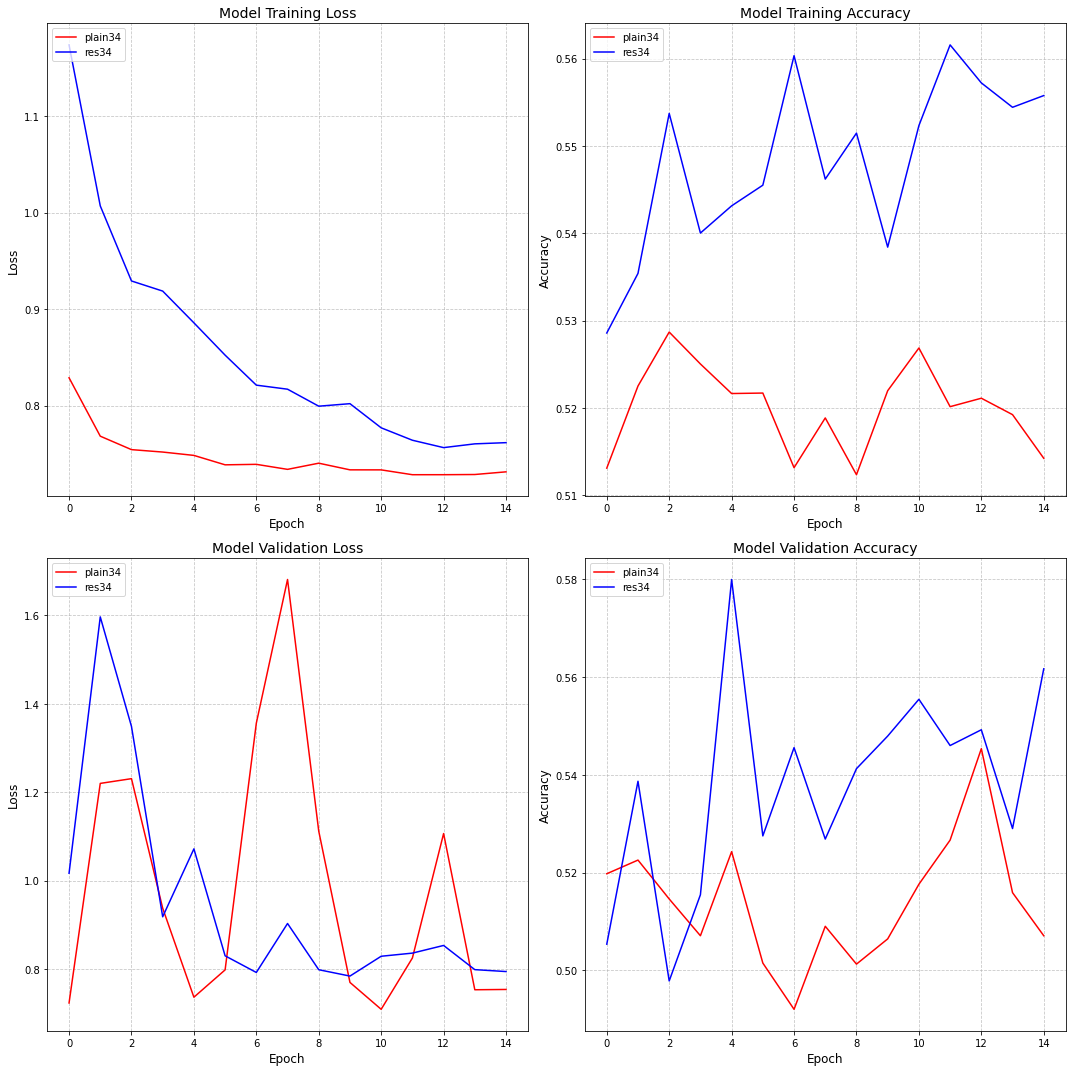

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# loss
axes[0][0].plot(history_plain34.history['loss'], 'r', label='plain34')
axes[0][0].plot(history_res34.history['loss'], 'b', label='res34')
axes[0][0].set_title('Model Training Loss', fontsize=14)
axes[0][0].set_ylabel('Loss', fontsize=12)
axes[0][0].set_xlabel('Epoch', fontsize=12)
axes[0][0].legend(loc='upper left', fontsize=10)
axes[0][0].grid(True, linestyle='--', alpha=0.7)

# acc
axes[0][1].plot(history_plain34.history['accuracy'], 'r', label='plain34')
axes[0][1].plot(history_res34.history['accuracy'], 'b', label='res34')
axes[0][1].set_title('Model Training Accuracy', fontsize=14)
axes[0][1].set_ylabel('Accuracy', fontsize=12)
axes[0][1].set_xlabel('Epoch', fontsize=12)
axes[0][1].legend(loc='upper left', fontsize=10)
axes[0][1].grid(True, linestyle='--', alpha=0.7)

# val_loss
axes[1][0].plot(history_plain34.history['val_loss'], 'r', label='plain34')
axes[1][0].plot(history_res34.history['val_loss'], 'b', label='res34')
axes[1][0].set_title('Model Validation Loss', fontsize=14)
axes[1][0].set_ylabel('Loss', fontsize=12)
axes[1][0].set_xlabel('Epoch', fontsize=12)
axes[1][0].legend(loc='upper left', fontsize=10)
axes[1][0].grid(True, linestyle='--', alpha=0.7)

# var_acc
axes[1][1].plot(history_plain34.history['val_accuracy'], 'r', label='plain34')
axes[1][1].plot(history_res34.history['val_accuracy'], 'b', label='res34')
axes[1][1].set_title('Model Validation Accuracy', fontsize=14)
axes[1][1].set_ylabel('Accuracy', fontsize=12)
axes[1][1].set_xlabel('Epoch', fontsize=12)
axes[1][1].legend(loc='upper left', fontsize=10)
axes[1][1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

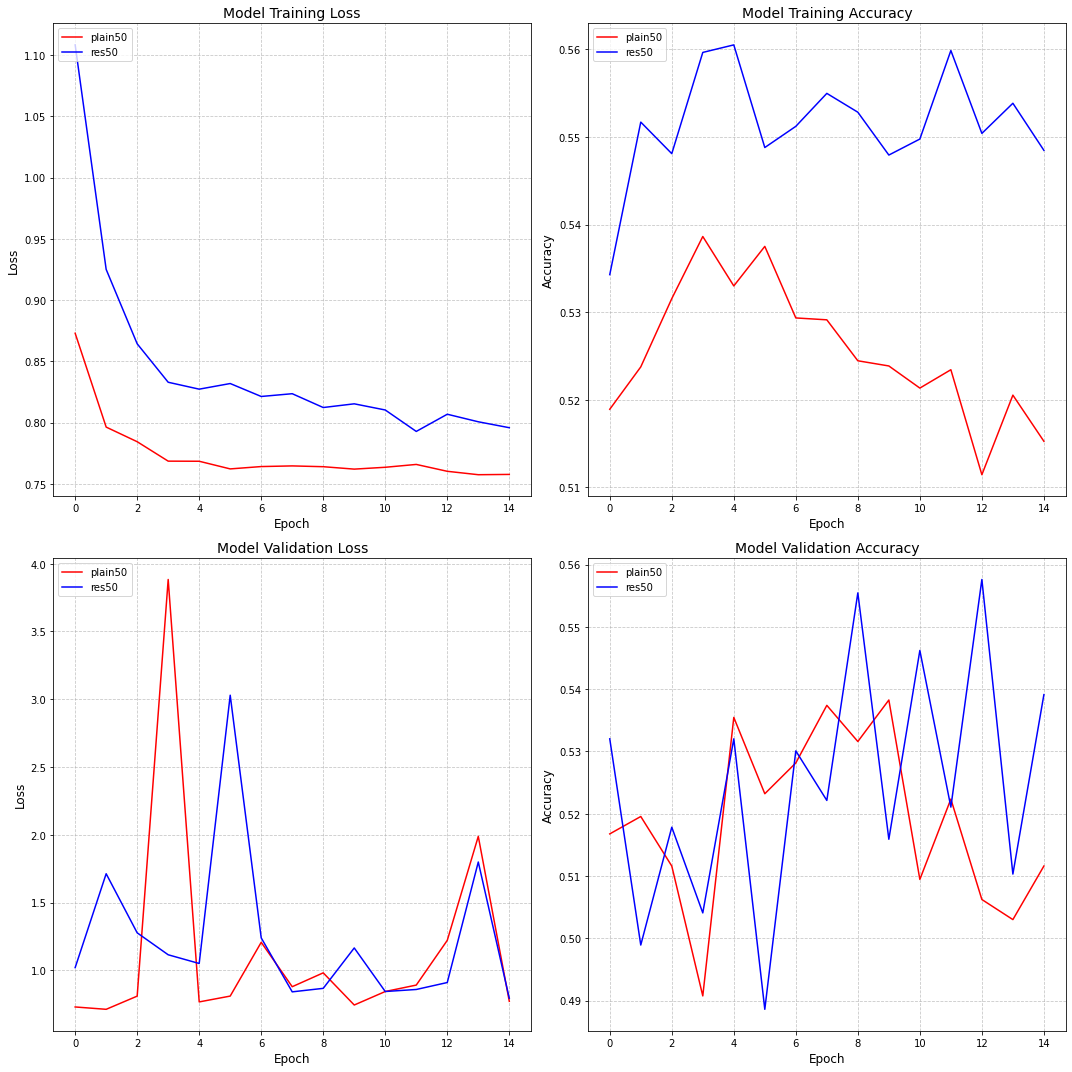

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# loss
axes[0][0].plot(history_plain50.history['loss'], 'r', label='plain50')
axes[0][0].plot(history_res50.history['loss'], 'b', label='res50')
axes[0][0].set_title('Model Training Loss', fontsize=14)
axes[0][0].set_ylabel('Loss', fontsize=12)
axes[0][0].set_xlabel('Epoch', fontsize=12)
axes[0][0].legend(loc='upper left', fontsize=10)
axes[0][0].grid(True, linestyle='--', alpha=0.7)

# acc
axes[0][1].plot(history_plain50.history['accuracy'], 'r', label='plain50')
axes[0][1].plot(history_res50.history['accuracy'], 'b', label='res50')
axes[0][1].set_title('Model Training Accuracy', fontsize=14)
axes[0][1].set_ylabel('Accuracy', fontsize=12)
axes[0][1].set_xlabel('Epoch', fontsize=12)
axes[0][1].legend(loc='upper left', fontsize=10)
axes[0][1].grid(True, linestyle='--', alpha=0.7)

# val_loss
axes[1][0].plot(history_plain50.history['val_loss'], 'r', label='plain50')
axes[1][0].plot(history_res50.history['val_loss'], 'b', label='res50')
axes[1][0].set_title('Model Validation Loss', fontsize=14)
axes[1][0].set_ylabel('Loss', fontsize=12)
axes[1][0].set_xlabel('Epoch', fontsize=12)
axes[1][0].legend(loc='upper left', fontsize=10)
axes[1][0].grid(True, linestyle='--', alpha=0.7)

# var_acc
axes[1][1].plot(history_plain50.history['val_accuracy'], 'r', label='plain50')
axes[1][1].plot(history_res50.history['val_accuracy'], 'b', label='res50')
axes[1][1].set_title('Model Validation Accuracy', fontsize=14)
axes[1][1].set_ylabel('Accuracy', fontsize=12)
axes[1][1].set_xlabel('Epoch', fontsize=12)
axes[1][1].legend(loc='upper left', fontsize=10)
axes[1][1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### cifar-10
![34cifar10](https://github.com/user-attachments/assets/579d0686-4a8f-419d-8033-42d26ae4878d)
![50cifar10](https://github.com/user-attachments/assets/0e767743-47df-42b4-b0d7-e1e6f1a561a4)

### 회고
- cifar-10의 데이터를 사용할 때보다 cats_vs_dogs를 사용할 때 이미지의 크기에 비례한 훈련속도 증가가 있었습니다.
- 처음 실수로 resnet_50에서 약 1.4억개의 파라미터를 가진 모델을 만들어서 훈련이 진행되었는데 마찬가지로 훈련시간이 비례적으로 증가했습니다.
    - cifar-10에서 약 2100만개의 파라미터 : 약 20초
    - cifar-10에서 약 1.4억개의 파라미터 : 약 120초
- cifar-10에서 validation loss와 validation accuracy가 많이 요동치는 모습을 보여줬지만 에폭수가 적어서 그렇다고 생각했습니다.
- cifar-10에서 학습이 진행됨에 따라 res_34가 plain_34보다 좋은 성능을 보여주었습니다.
- cifar-10에서 res_50과 plain_50은 결과가 비슷했습니다. 더 많은 에폭을 두고 결과를 관찰해야 할 것 같습니다.
- 모델을 구성할 때 논문상의 conv3_1, conv4_1, conv5_1에서 다운샘플링을 진행하는데 이를 위해서 1x1의 커널을 갖는 conv층을 하나 두게 되었습니다. 이걸 conv층을 두지않고 다르게 처리할 수 있는지를 공부해야 합니다.
    - 파라미터 수가 증가하기 때문에 파라미터가 증가하지 않고 다운샘플링하는 법을 찾아봐야 할 것입니다.
    - conv레이어의 필터가 1x1이라 하더라도 3채널간의 convolution은 일어나기 때문에 좀더 데이터가 가공되지 않는 방향으로의 방법이 궁금합니다.
- cats_vs_dogs에서도 cifar-10과 비슷한 결과가 나왔다.